In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
import itertools

import warnings
warnings.filterwarnings("ignore")

In [36]:
btc_df = pd.read_csv(r'sentiment_btc.csv', index_col=0)
eth_df = pd.read_csv(r'sentiment_eth.csv', index_col=0)
price_df = pd.read_csv(r'Prices.csv', index_col=0)

In [37]:
btc_df.head(2)

,Date,Retweet,Reply,Likes,Tweet,roberta_neg,roberta_neu,roberta_pos,classes
0,2020-01-01 18:23:45+00:00,82,1,2989,@NightlyEspresso @twilightsthorn Shrek 5: Inve...,0.035846,0.865769,0.098386,0
1,2020-01-01 02:20:38+00:00,362,43,2018,This decade was bitcoin just warming up.,0.029965,0.760136,0.209899,0


In [38]:
eth_df.head(2)

,Date,Retweet,Reply,Likes,Tweet,roberta_neg,roberta_neu,roberta_pos,classes
0,2020-01-01 08:18:15+00:00,126,57,979,If you bought any crypto and it went up over 1...,0.800818,0.171669,0.027513,-1
1,2020-01-01 20:15:56+00:00,161,179,941,I found @CryptoKitties the most interesting cr...,0.001476,0.022359,0.976166,1


In [39]:
price_df.head(2)

,+1D BTC,+1D ETH,Price Diff BTC,Price Diff ETH,BTC_close,ETH_close
Date,,,,,,
2015-08-08 23:59:59,1,0,4.085999,-0.051428,260.997009,0.753325
2015-08-09 23:59:59,0,1,-0.613007,0.006551,265.083008,0.701897


## Pre-Processing

In [40]:
price_df = price_df['2020-01-01 00:00:00':'2020-05-30 00:00:00']
price_df.index = pd.to_datetime(price_df.index, utc=True)
price_df = price_df.sort_values(by='Date')
price_df.index = price_df.index.date
price_df.index.name = 'Date'

In [41]:
def PreProc(df, price_df=price_df):
    df['Date'] = pd.to_datetime(df['Date'], utc=False)
    df = df.set_index('Date')

    df = df.drop(columns='Tweet', axis=0)
    df = df.sort_values('Date')

    merge_df = df
    merge_df.index = merge_df.index.date
    merge_df.index.name = 'Date'

    merge_df['Impact'] = 2*merge_df['Retweet']*merge_df['classes'] + merge_df['Likes']*merge_df['classes']
    merge_df = pd.get_dummies(merge_df, columns=['classes'])

    merge_df = merge_df.groupby('Date')[['Impact', 'classes_-1', 'classes_1']].sum()
    merge_df = pd.merge(merge_df, price_df, on='Date')

    return merge_df

### BTC

In [42]:
btc_merge = PreProc(btc_df)
btc_merge.head()

,Impact,classes_-1,classes_1,+1D BTC,+1D ETH,Price Diff BTC,Price Diff ETH,BTC_close,ETH_close
Date,,,,,,,,,
2020-01-01,12907,10,38,0,0,-214.704392,-3.391826,7200.174393,130.802008
2020-01-02,12894,12,33,1,1,359.414183,6.761530,6985.470001,127.410182
2020-01-03,26914,13,52,1,1,65.772383,0.897659,7344.884183,134.171712
2020-01-04,9551,11,24,1,1,0.660760,1.207405,7410.656566,135.069371
2020-01-05,18484,16,26,1,1,357.901712,8.027377,7411.317327,136.276777


In [43]:
btc_merge = btc_merge.iloc[:, [0, 1, 2, 3, 5, 7]]

### ETH

In [44]:
eth_merge = PreProc(eth_df)
eth_merge.head()

,Impact,classes_-1,classes_1,+1D BTC,+1D ETH,Price Diff BTC,Price Diff ETH,BTC_close,ETH_close
Date,,,,,,,,,
2020-01-01,3861,6,13,0,0,-214.704392,-3.391826,7200.174393,130.802008
2020-01-02,7842,5,21,1,1,359.414183,6.761530,6985.470001,127.410182
2020-01-03,1949,12,15,1,1,65.772383,0.897659,7344.884183,134.171712
2020-01-04,5116,1,14,1,1,0.660760,1.207405,7410.656566,135.069371
2020-01-05,6867,6,11,1,1,357.901712,8.027377,7411.317327,136.276777


In [45]:
eth_merge = eth_merge.iloc[:, [0, 1, 2, 4, 6, 8]]

## Train-Test-Split

In [46]:
date1 = pd.to_datetime('2020-04-30').date()
date2 = pd.to_datetime('2020-05-01').date()

In [47]:
train = btc_merge[:date1]
test = btc_merge[date2:]

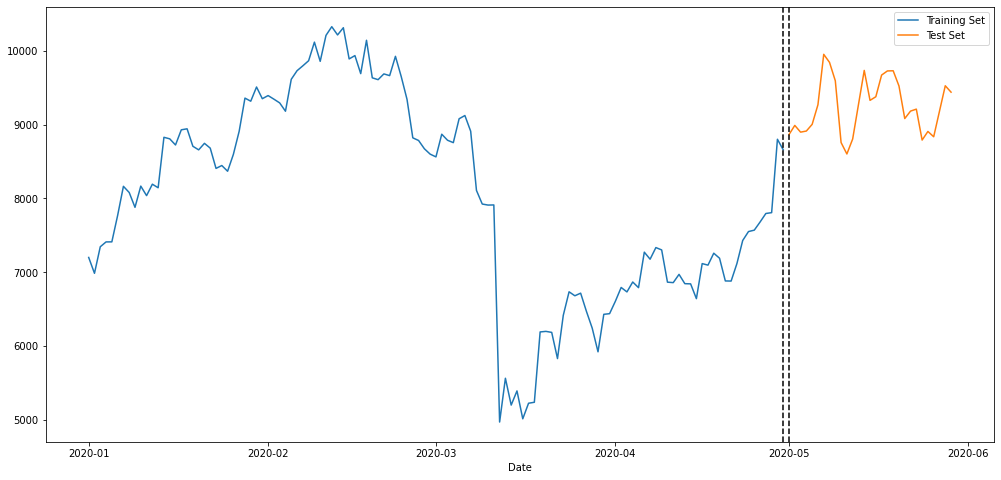

In [49]:
fig, ax = plt.subplots(figsize=(17, 8))
train['BTC_close'].plot(ax=ax, label='Training Set')
test['BTC_close'].plot(ax=ax, label='Test Set')
ax.axvline('2020-04-30', color='black', ls='--')
ax.axvline('2020-05-01', color='black', ls='--')
plt.legend()
plt.show()

In [50]:
train.tail()

,Impact,classes_-1,classes_1,+1D BTC,Price Diff BTC,BTC_close
Date,,,,,,
2020-04-26,1339,13,26,1,115.733630,7679.867204
2020-04-27,18703,18,46,1,11.457617,7795.600835
2020-04-28,41816,24,42,1,993.979316,7807.058451
2020-04-29,4882,36,65,0,-142.483587,8801.037767
2020-04-30,86255,27,76,1,206.212628,8658.554180


In [51]:
test.head()

,Impact,classes_-1,classes_1,+1D BTC,Price Diff BTC,BTC_close
Date,,,,,,
2020-05-01,-17651,21,37,1,123.829399,8864.766808
2020-05-02,15698,12,31,0,-91.127697,8988.596207
2020-05-03,7312,27,30,1,15.186096,8897.468510
2020-05-04,26103,20,41,1,90.415573,8912.654605
2020-05-05,27263,27,55,1,265.691902,9003.070178


In [52]:
train = eth_merge[:date1]
test = eth_merge[date2:]

In [69]:
x_train = train.iloc[:, [0,1,2,4]]
y_train = train.iloc[:, 3]

x_test = test.iloc[:, [0,1,2,4]]
y_test = test.iloc[:, 3]

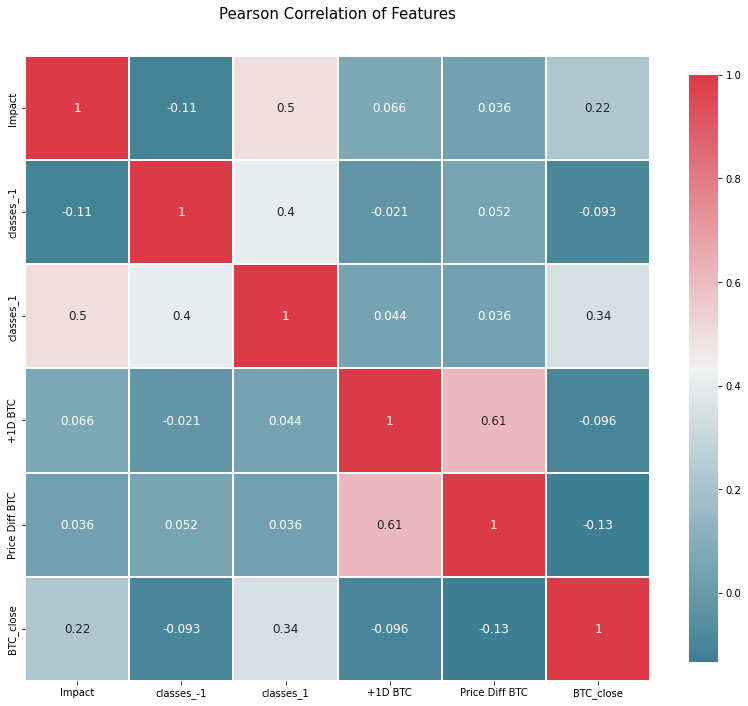

In [81]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(btc_merge)

## Model

### Prediksi

### Klasifikasi

In [70]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [71]:
scores = cross_val_score(model, x_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.98


In [72]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.99


In [73]:
def plot_confusion_matrix(cm, classes, 
                            normalize=False, 
                            title='Confusion matrix', 
                            cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [74]:
def Evaluation(model, X_train, y_train, X_test, y_test):
    pred = model.predict(X_train)
    yhat = model.predict(X_test)
    print(classification_report(y_test, yhat))
    print("_______________________________________________")

    train_score = accuracy_score(y_train, pred) * 100
    test_score = accuracy_score(y_test, yhat) * 100

    print(f"Train accuracy Score: {train_score}%")
    print(f"Test accuracy Score: {test_score}%")

    cnf = confusion_matrix(y_test, yhat, labels=[1,0])
    plt.figure()
    plot_confusion_matrix(cnf,classes=['output =1', 'output=0'],normalize = False, title='Confusion matrix')

    return  train_score, test_score, cnf

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        16

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29

_______________________________________________
Train accuracy Score: 100.0%
Test accuracy Score: 100.0%
Confusion matrix, without normalization
[[16  0]
 [ 0 13]]


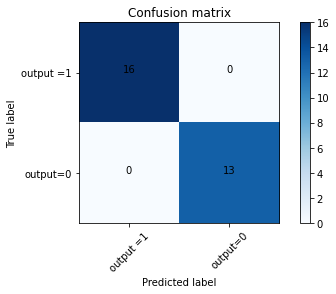

In [75]:
x, y, cnf = Evaluation(model, x_train, y_train, x_test, y_test)

results_df = pd.DataFrame(data=[["XGBoost", x, y]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])